In [105]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit


In [106]:
dataset_path_1st = '1st_test'
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result
# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())
# extract shannon entropy (cut signals to 500 bins)

def time_features(dataset_path):
    time_features = ['mean','std','rms','max','p2p']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    
    # initialize
   
    columns = [c+'_'+tf for c in cols1 for tf in time_features]
    data = pd.DataFrame(columns=columns)

        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
       
  
        mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
        std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
        rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
        max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
        p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
      
       
            
        mean_abs.index = [filename]
        std.index = [filename]
      
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
      
        
        # concat
        merge = pd.concat([mean_abs, std, rms, max_abs, p2p], axis=1)
        data = pd.concat([data, merge])
    cols = [c+'_'+tf for c in cols1 for tf in time_features]
    data = data[cols]
  
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data    

In [107]:
set1 = time_features(dataset_path_1st)
set1.to_csv('set1_timefeatures.csv')


C:\Users\datpr\AppData\Local\Temp\ipykernel_12352\3885183854.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, merge])


In [ ]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set1 = set1.rename(columns={'Unnamed: 0':'time'})
#set1 = set1.set_index('time')
last_cycle = int(len(set1))

In [ ]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set1 = set1.rename(columns={'Unnamed: 0':'time'})
#set1 = set1.set_index('time')
last_cycle = int(len(set1))


In [ ]:
features = set1.copy()
#simple moving average SMA
ma = pd.DataFrame()
ma['B4_x_mean'] = features['B4_x_mean']
ma['SMA'] = ma['B4_x_mean'].rolling(window=5).mean()
ma['time'] = features['time']
#Cumulative Moving Average
ma['CMA'] = ma["B4_x_mean"].expanding(min_periods=10).mean()
#Exponantial Moving Average
ma['EMA'] = ma['B4_x_mean'].ewm(span=40,adjust=False).mean()

<Axes: xlabel='time'>

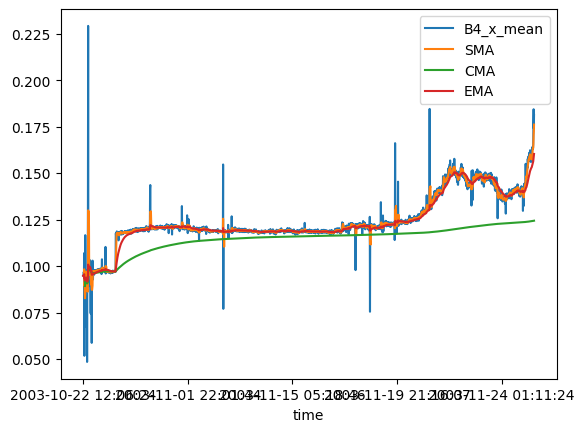

In [ ]:
ma.plot(x="time", y= ['B4_x_mean','SMA','CMA','EMA'])

In [ ]:
def health_indicator(bearing_data,use_filter=False):    
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)
    
    return degredation

def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(degredation.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq
log = [[],[]]

In [ ]:
#variable for incrementing index
prediction_cycle = 600
#variable for keeping intial value
init_cycle = prediction_cycle

In [ ]:
#selected_features = ['mean','std','kurtosis','skew','entropy',
#        'rms','max','p2p','crest','shape','impulse']
selected_features = ['max','p2p','rms']

bearing = 3
B_x = ["B{}_x_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_x][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9955862512721826


Explained variance of Pricincipal Component 1 is:0.9956274322666577
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.994738878585239
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9944323438515958
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9945131999470982
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9943348936040264
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.994065675149865
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9941425509350195
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9942258600849837
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.994318212879631
Xác suất xảy ra của Failed_Cycle là: 0.

C:\Users\datpr\AppData\Local\Temp\ipykernel_12352\367446312.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9956944174532368
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9955628001810272
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9955539706656837
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9955892409489552
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9956128207836734
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9956577797932161
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.995641050206156
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9956969166426684
Xác suất xảy ra của Failed_Cycle là: 0.0000
Explained variance of Pricincipal Component 1 is:0.9957357993

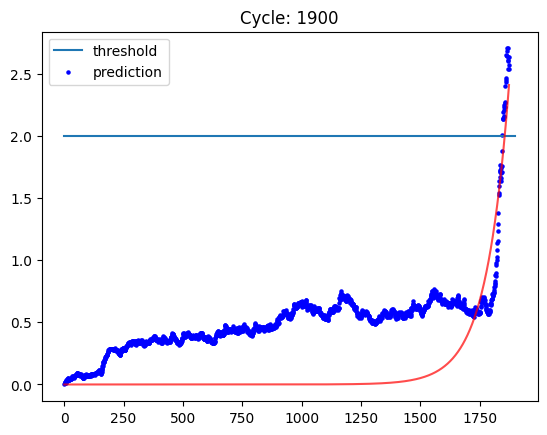

In [ ]:




results_df = pd.DataFrame(columns=['prediction_Cycle', 'Prediction', 'Failed_Cycle','failure_probability'])

while prediction_cycle < fail_cycle :
    data = set1[B_x][:prediction_cycle]
    ind=data.index
    degredation = health_indicator(data,use_filter=True)
    #degredation.plot(y='PC1',x='cycle')
    fit = fit_exp(degredation,base=250)

    prediction = predict(degredation,fit)
    m,n = fit[0]
    thres = 2
    #print(prediction_cycle)
    fail_cycle = (np.log(thres/m))/abs(n)
    log[0].append(prediction_cycle)
    log[1].append(fail_cycle)

    increment_cycle =25
    prediction_cycle += increment_cycle
  
    temp_df = pd.DataFrame({'prediction_Cycle': [prediction_cycle], 'Prediction': [prediction], 'Failed_Cycle': [fail_cycle]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
  

print(results_df)
results_df.to_csv('result.csv', index=False)


fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show() 